# Behavioral Cloning with Keras Project


## Load the data

In [1]:
# Load images into an array
from skimage.io import imread_collection
from skimage.io import concatenate_images

print("Loading images...")
images = imread_collection('track1_IMG/center*.jpg')
image_array = concatenate_images(images)
print("Finished loading images.")

Loading images...
Finished loading images.


In [2]:
# Load Steering angles into array
import numpy as np
from numpy import genfromtxt

print("Loading steering angles...")
file_data = genfromtxt('track1_driving_log.csv', delimiter=',')
print("Finished loading steering angles.")

Loading steering angles...
Finished loading steering angles.


In [42]:
import random
index = random.randint(0, len(image_array))
angle = file_data[...,3]
angle[index]

-0.1188574

Angle of  -0.1188574
Image at index:  786
Image dimensions are  (160, 320, 3)


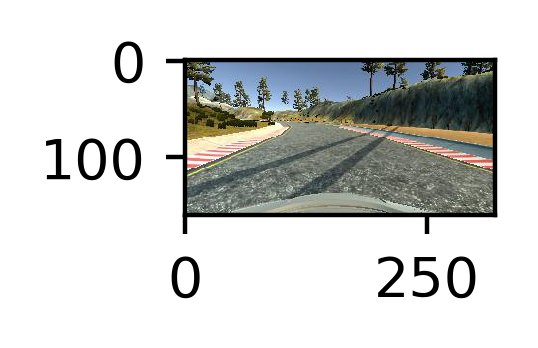

In [43]:
# Visualize the images
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

image = image_array[index]

plt.figure(figsize=(1,1),dpi=400)
plt.imshow(image)
print("Angle of ",angle[index])
print("Image at index: ", index)
print("Image dimensions are ", image.shape)

# Preprocessing

## Normalize function

In [44]:
def normalizer(array, min_max=(0,1), feature_range=(0, 1)):
    x_min = feature_range[0]
    x_max = feature_range[1]
    a = min_max[0]
    b = min_max[1]
    norm_features = (array-x_min)*(b-a)/(x_max - x_min) + a
    return norm_features

## Normalize steering angle

I decided to normalize the steering angle to between -0.5 and 0.5 to have a unit spread and a mean of 0.

Steering of -1 correspnds to -25 degrees and 1 +25 degrees.

In [45]:
# Normalize the steering angles to between -0.5 and 0.5. They are currently recorded to between -1.0 and 1.0
print("Normalizing steering angles...")
angle_nomalized = normalizer(angle, min_max=(-0.5,0.5), feature_range=(-1.0,1.0))
print("Steering angles normalized")

Normalizing steering angles...
Steering angles normalized


## Reduce image size
Don't need as many features which will overly complexify the training

In [46]:
from skimage.transform import resize

In [47]:
print("Resizing images...")
resized_images = [resize(image,(80,160),preserve_range=True) for image in image_array]
resized_images = np.array(resized_images)
resized_images = np.copy(resized_images).astype('uint8')
print("Images resized...")

Resizing images...
Images resized...


<class 'numpy.ndarray'>


numpy.ndarray

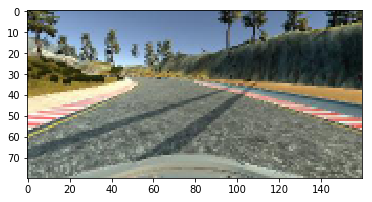

In [48]:
plt.imshow(resized_images[index])
print(type(resized_images))
type(np.array(resized_images))

## Normalize image channels

I normalized the image channels to between 0 and 1, moving 0 to 0 and 255 to 1

In [49]:
# Normalize the image channels to between 0 and 1
print("Normalizing image channels...")
normalized_images = normalizer(resized_images, min_max=(0,1), feature_range=(0,255))
print("Normalization complete")

Normalizing image channels...
Normalization complete


In [50]:
print(image_array[0,0,0])
print(resized_images[0,0,20])
print(normalized_images[0,0,0])

[116 145 185]
[106 134 174]
[ 0.45490196  0.56862745  0.7254902 ]


# Shuffle the data

In [67]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(normalized_images, angle_nomalized)

## Split the data into train, validation and test data

In [68]:
# Perform a train / test split

from sklearn.model_selection import train_test_split

print("Split into train, validation and test data")
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=36)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=36)
print("Train size {}, validation size {}, test size {}".format(len(y_train), len(y_validation), len(y_test)))

Split into train, validation and test data
Train size 948, validation size 237, test size 791


## Save the data into a pickle so we don't have to process every time

In [69]:
import pickle

pickle_out = open('image_data.pkl', 'wb')
pickle.dump([X_train, X_validation, X_test, y_train, y_validation, y_test], pickle_out)
pickle_out.close()

## Load the file from a pickle

In [70]:
data_file = open('image_data.pkl', 'rb')
X_train, X_validation, X_test, y_train, y_validation, y_test = pickle.load(data_file)
data_file.close()

In [76]:
print("Data loaded with training size of {}, validation size of {}, and test size of {}.".format(len(X_train), len(X_validation), len(X_test)))

Data loaded with training size of 948, validation size of 237, and test size of 791.


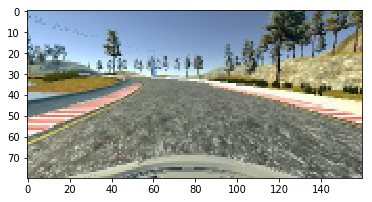

In [77]:
plt.imshow(X_train[index])

In [103]:
print("Start model. Input shape is ",X_train.shape[1:])
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Activation, Flatten, Dropout
from keras.layers import Dense
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

print("1st Layer")
model = Sequential()
model.add(Convolution2D(24, 4, 4,input_shape=X_train.shape[1:],subsample=(2, 2)))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))
model.add(Activation('relu'))

print("2nd Layer")
model.add(Convolution2D(36, 4, 4,subsample=(2, 2)))
#model.add(MaxPooling2D((4, 4)))
#model.add(Dropout(0.5))
model.add(Activation('relu'))

print("3rd Layer")
model.add(Convolution2D(48, 4, 4,subsample=(2, 2)))
#model.add(MaxPooling2D((4, 4)))
#model.add(Dropout(0.5))
model.add(Activation('relu'))

print("4th Layer")
model.add(Convolution2D(64, 3, 3,border_mode='same'))
#model.add(MaxPooling2D((4, 4)))
#model.add(Dropout(0.5))
model.add(Activation('relu'))

print("5th Layer")
model.add(Convolution2D(64, 3, 3,border_mode='same'))
#model.add(MaxPooling2D((4, 4)))
#model.add(Dropout(0.5))
model.add(Activation('relu'))

print("6th Layer")
model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))
          
model.add(Dense(1))

# Train the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=20, nb_epoch=20, validation_split=0.0, validation_data=(X_validation, y_validation))

Start model
1st Layer
2nd Layer
3rd Layer
4th Layer
5th Layer
6th Layer
Train on 948 samples, validate on 237 samples
Epoch 1/20
948/948 [==============================] - 19s - loss: 0.0019 - acc: 0.3080 - val_loss: 0.0012 - val_acc: 0.2996

KeyboardInterrupt: 